In [1]:
!pip install scikit-fmm

In [2]:
import numpy as np
import skfmm
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

In [3]:
# Example grid and speed setup
N = 101
h = 0.1
x = np.linspace(0, N * h, N)
y = np.linspace(0, N * h, N)
X, Y = np.meshgrid(x, y)
F = 1.2 - 0.3 * np.exp(-((X - 0.5) ** 2 + (Y - 0.5) ** 2) / 0.05)

In [4]:
# Define source and initialize phi
source = np.array([[21, 21], [71, 71]])  # Source points
phi = np.ones((N, N))
for sx, sy in source:
    phi[sx, sy] = 0

In [5]:
# Calculate travel times with scikit-fmm
travel_times = skfmm.travel_time(phi, speed=F, order=2, dx=h)

In [6]:
# Compute the gradient of the travel time field
grad_y, grad_x = np.gradient(travel_times, h, h)

# Create interpolators with linear interpolation
interp_grad_x = RegularGridInterpolator((y, x), grad_x, method='cubic')
interp_grad_y = RegularGridInterpolator((y, x), grad_y, method='cubic')

# Ray tracing system of ODEs
def ray_equations(s, coords):
    x, y = coords
    # Interpolate gradient values at the current position
    if 0 <= x <= N * h and 0 <= y <= N * h:
        grad_x_val = interp_grad_x((y, x))
        grad_y_val = interp_grad_y((y, x))
    else:
        # Out of bounds: stop propagation by setting the derivatives to zero
        grad_x_val = 0
        grad_y_val = 0

    # The direction of travel follows the negative gradient (for steepest descent)
    return [-grad_x_val, -grad_y_val]

In [7]:
# Specify starting point for tracing
start_point = (6.0, 2.0)  # Adjust as necessary; starting point in the continuous domain

# Integrate the ray equations
solution = solve_ivp(
    ray_equations,
    [0, 10],  # Integration interval; extend as necessary for longer paths
    start_point,
    method='RK45',
    dense_output=True,
    max_step=0.1  # Small steps for accuracy
)

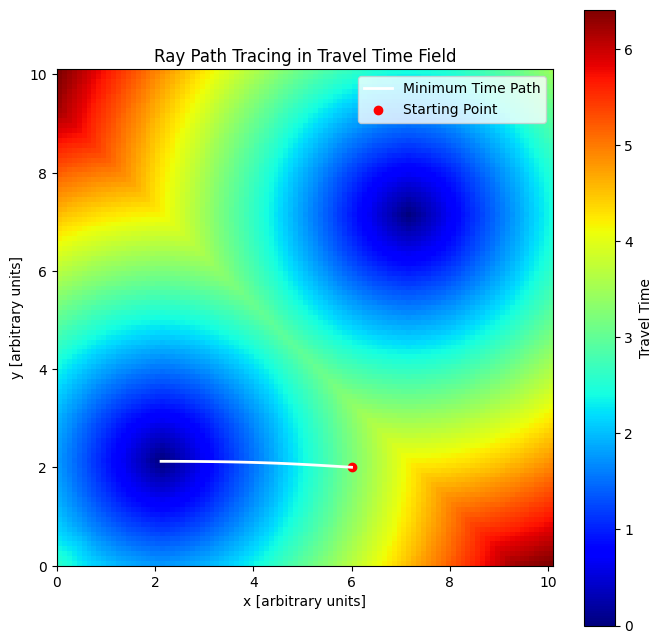

In [8]:
# Plot the travel time field and ray path
fig, ax = plt.subplots(figsize=(8, 8))
c = ax.imshow(travel_times, cmap='jet', extent=(0, N * h, 0, N * h), origin='lower')
fig.colorbar(c, ax=ax, label="Travel Time")
path_x, path_y = solution.y[0], solution.y[1]
ax.plot(path_x, path_y, 'w-', linewidth=2, label="Minimum Time Path")
ax.scatter(*start_point, color='red', label="Starting Point")
ax.set_title("Ray Path Tracing in Travel Time Field")
ax.set_xlabel("x [arbitrary units]")
ax.set_ylabel("y [arbitrary units]")
ax.legend()
plt.show()